## Natural Cubic Spline Basis Generation

A natural cubic spline with $ K $ knots can be represented as:

$$ f(x) = \beta_0 + \beta_1 x + \sum_{k=1}^{K} \beta_{k+1} (x - c_k)^3_+ $$
where $ (x - c_k)^3_+ $ denotes $ (x - c_k)^3 $ if $ x > c_k $ and 0 otherwise, and $ c_k $ are the knots.

We use the `dmatrix` function from `patsy` to generate the natural cubic spline basis. The number of degrees of freedom (df) for $ K $ knots is $ K+2 $.

```python
K = 11
df = K +2
transformed_X = dmatrix(f"cr(X, df={df})", {"X": X}, return_type='dataframe')
```

## Model Fitting

With the spline basis ready, we fit a Generalized Linear Model (GLM) using `statsmodels`.

```python
model = sm.GLM(y, transformed_X)
results = model.fit()
```

## Predictions and Confidence Intervals

After fitting the model, we compute the residuals, variance of the residuals, and the standard error for each prediction.

The hat matrix, $ S $, is calculated as:
$$ S = X (X^T X)^{-1} X^T $$
where $ X $ is the design matrix.

The variance of the residuals $ \sigma^2 $ is given by:
$$ \sigma^2 = \frac{1}{n - \text{trace}(S)} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $$

The standard error for each prediction is the square root of the diagonal of $ \sigma^2 \times S $.

Confidence intervals (95%) for the spline estimates are calculated as:
$$ \hat{y} \pm 1.96 \times \text{SE} $$

<b>Reference:</b> From GaTech ISYE 8803 High Dimensional Data Analytics lecture notes, enhanced with ChatGPT.

C:\Users\nmert\AppData\Local\Temp\ipykernel_6244\584389158.py:35: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(sigma2 * S))


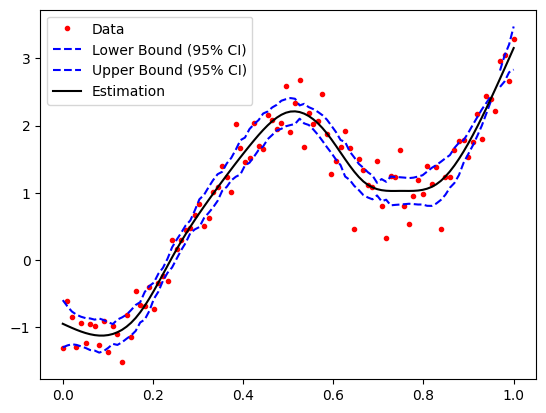

In [3]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrix

# Generate data
n = 100
X = np.linspace(0, 1, n)
sigma = 0.3
fun = lambda x: 2.5 * x - np.sin(10 * x) - np.exp(-10 * x)
y = fun(X) + np.random.randn(n) * sigma

# Generate natural cubic spline basis using patsy's dmatrix
K = 11
df = K +2
# cr stands for Natural Cubic Spline Basis
transformed_X = dmatrix(f"cr(X, df={df})", {"X": X}, return_type='dataframe')

# Fit the model
model = sm.GLM(y, transformed_X)
results = model.fit()

# Predict
y_pred = results.predict(transformed_X)

# Compute residuals
res = y - y_pred

# Compute variance of residuals
S = np.dot(transformed_X.values, np.dot(np.linalg.inv(np.dot(transformed_X.T.values, transformed_X.values)), transformed_X.T.values))
K = np.trace(S)
sigma2 = np.var(res, ddof=int(K))

# Compute standard error for each prediction
se = np.sqrt(np.diag(sigma2 * S))

# Compute the lower and upper bounds for the confidence intervals
yn = y_pred - 1.96 * se
yp = y_pred + 1.96 * se

# Plot function:
plt.plot(X, y, 'r.', label='Data')
plt.plot(X, yn, 'b--', label='Lower Bound (95% CI)')
plt.plot(X, yp, 'b--', label='Upper Bound (95% CI)')
plt.plot(X, y_pred, 'k-', label='Estimation')
plt.legend()
plt.show()
